In [1]:
import numpy as np
import seaborn as sns
from scipy import stats
import scipy
import pickle

def minmax(vec):
    vec=np.array(vec)
    vec[vec<0]=0
    _min=np.min(vec)
    _max=np.max(vec)
    return (vec-_min)/(_max-_min)

def zscore(vec):
    return stats.zscore(vec)
    
cancerTypes = ['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'COADREAD', 'DLBC', 'ESCA', 'GBM', 'GBMLGG', 'HNSC',
                   'KICH', 'KIPAN', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG',
                   'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'STES', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM']
colors=sns.color_palette('Pastel1')+sns.color_palette('Pastel2')+sns.color_palette('Paired')+sns.color_palette('tab20c')
len(colors)

data = np.load("../data/data_norm_log10_format.npy",allow_pickle=True).item()
allGenes=np.array(data['features'])

cancerBasedData={}
for sample in data['samples']:
    try:
        cancerBasedData[sample['cancertype']].append(zscore(sample['genes']))
    except:
        #cancerBasedData[sample['cancertype']]=[sample['genes']]
        cancerBasedData[sample['cancertype']]=[zscore(sample['genes'])]
        
with open('allGenes.pkl', 'wb') as handle:
    pickle.dump(allGenes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('cancerBasedData.pkl', 'wb') as handle:
    pickle.dump(cancerBasedData, handle, protocol=pickle.HIGHEST_PROTOCOL)

PureSGD_data1_rep0_e5_H3_R1_D0_modelbest.tar
KstestResult(statistic=0.3939393939393939, pvalue=1.5130919031319353e-07)
KstestResult(statistic=0.3838383838383838, pvalue=3.4230603710197877e-07)
KstestResult(statistic=0.3939393939393939, pvalue=1.5130919031319353e-07)
KstestResult(statistic=0.31313131313131315, pvalue=5.4307054517454265e-05)


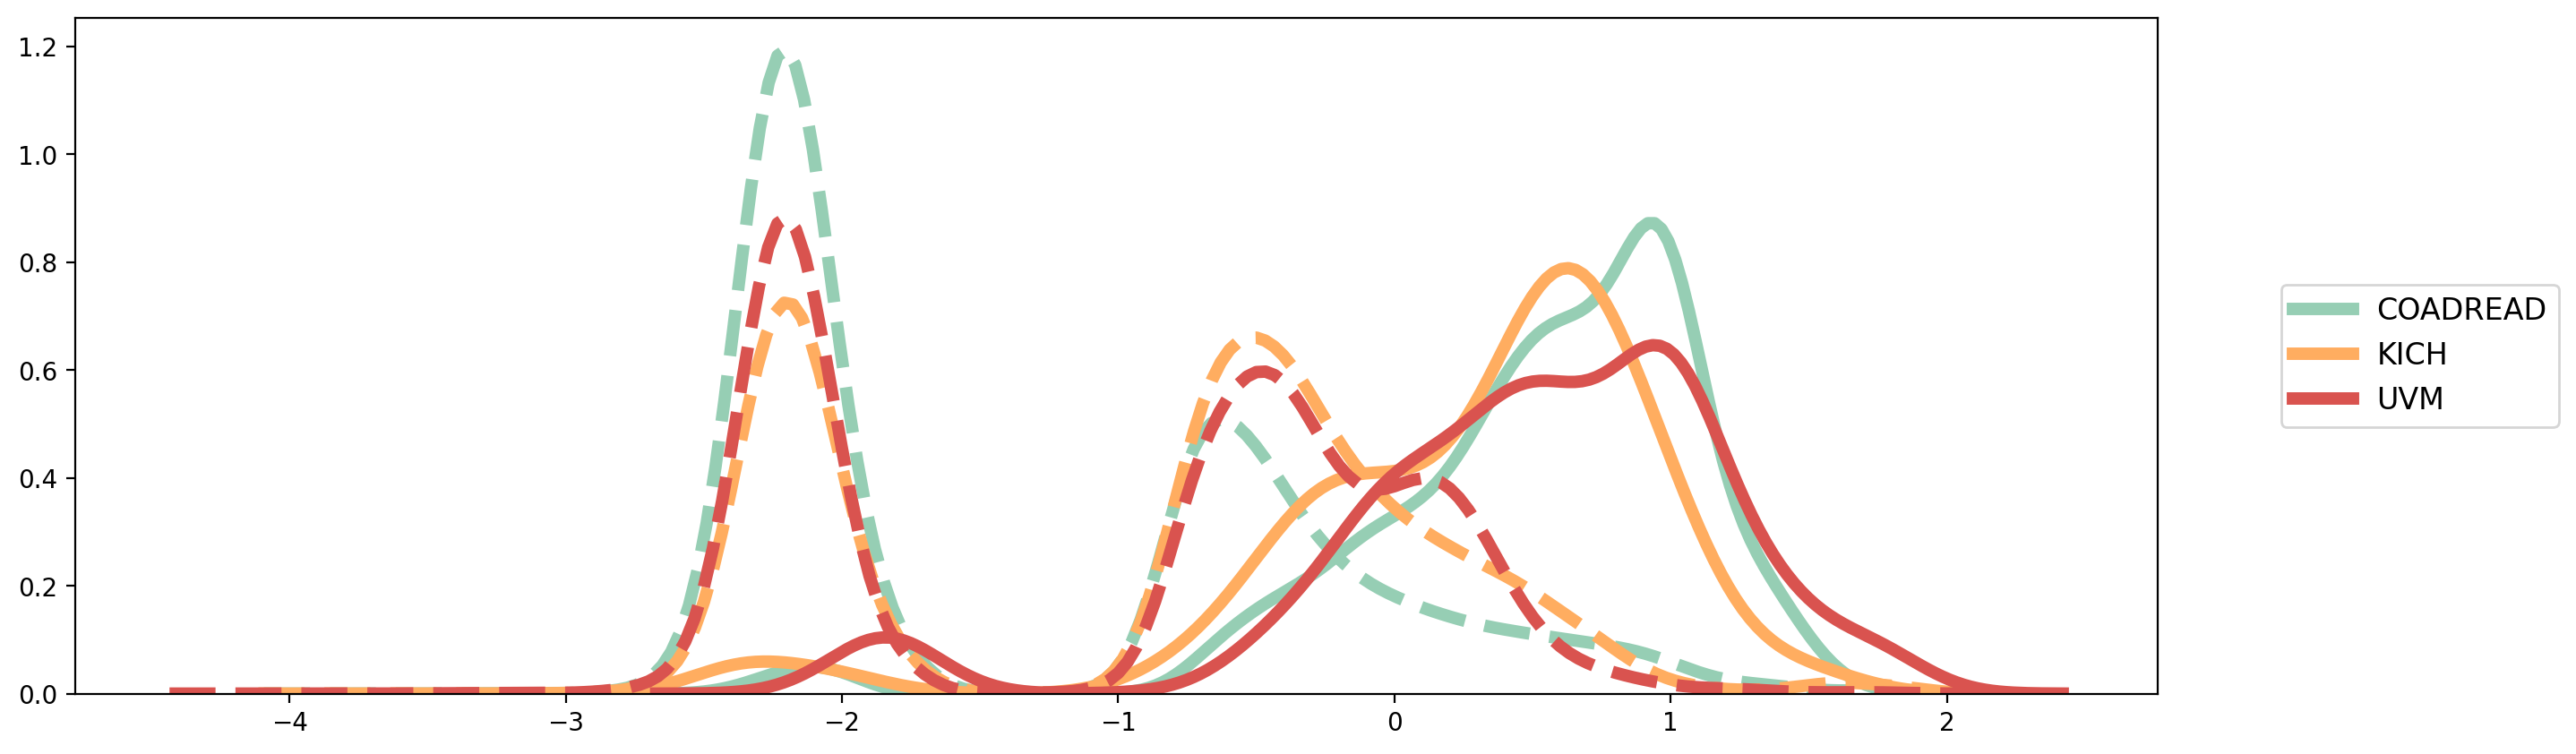

DPSM_data1_rep0_e5_H3_R1_D0_modelbest.tar
KstestResult(statistic=0.3333333333333333, pvalue=1.4308520725278836e-05)
KstestResult(statistic=0.43434343434343436, pvalue=4.544866444549687e-09)
KstestResult(statistic=0.42424242424242425, pvalue=1.1322298861860624e-08)
KstestResult(statistic=0.35353535353535354, pvalue=3.4442573174417127e-06)


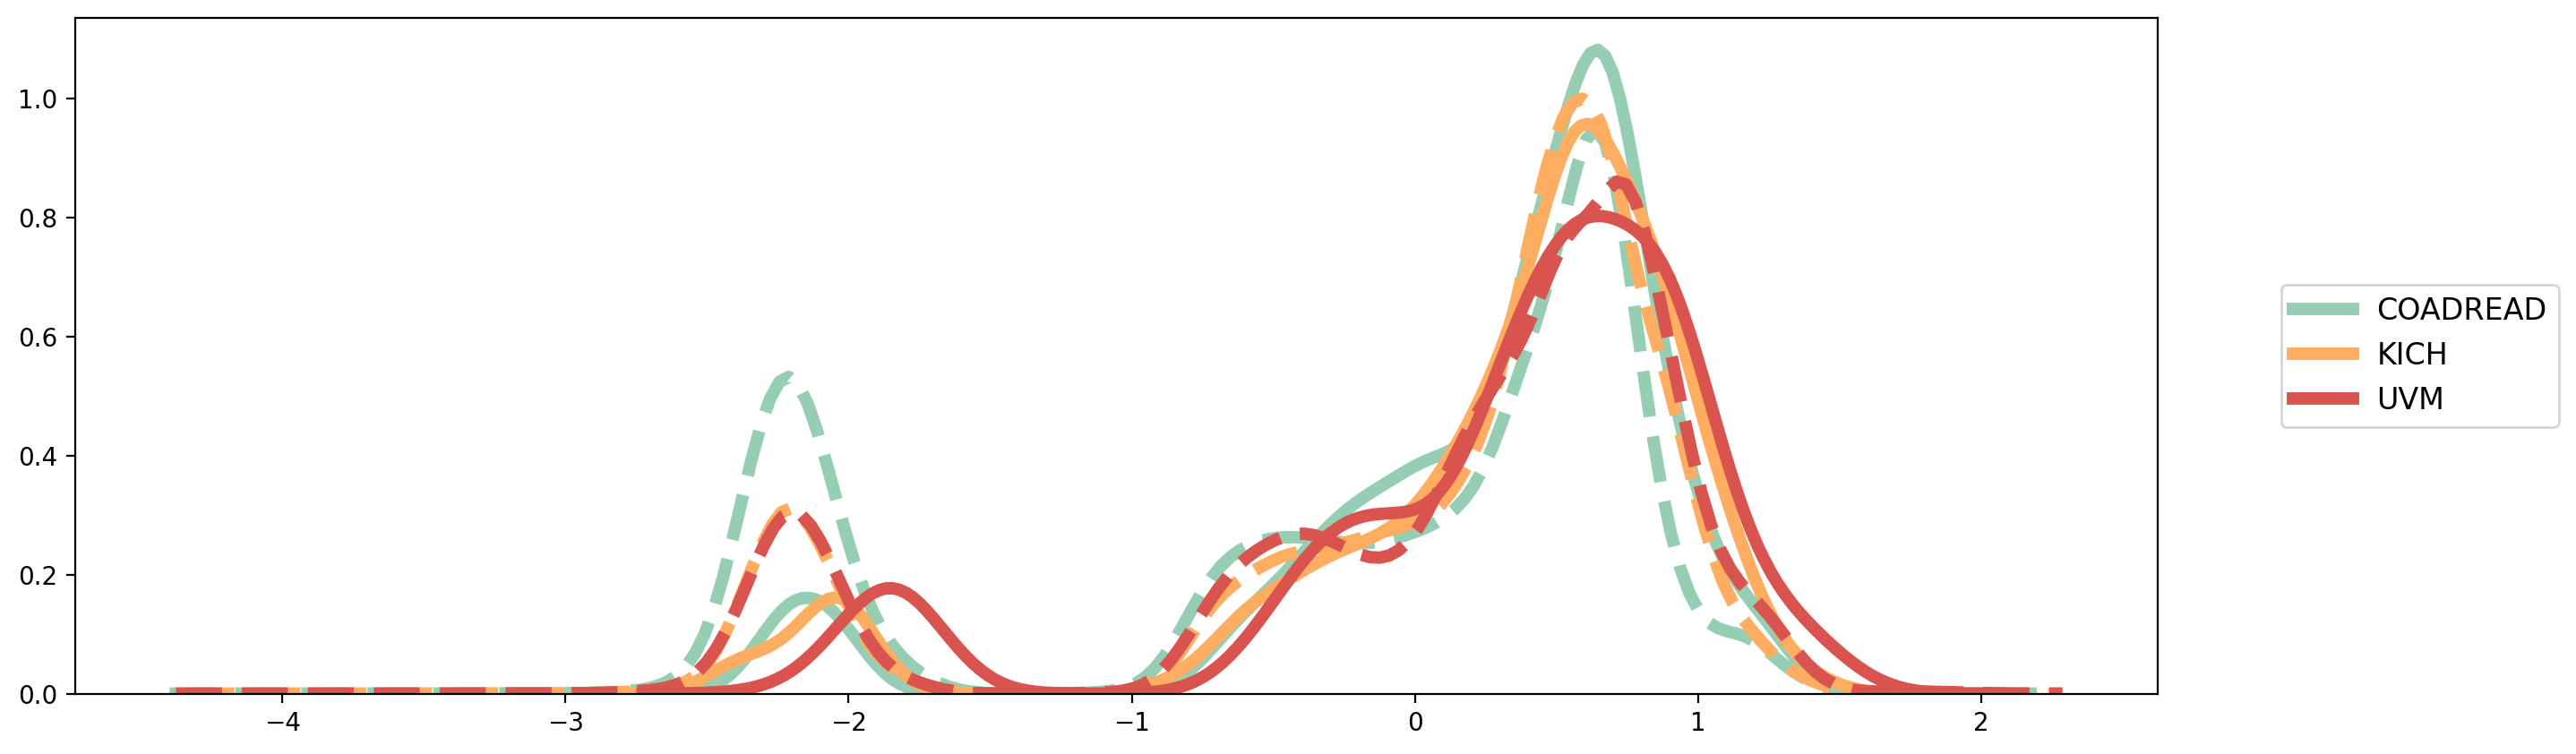

In [40]:
from sklearn.metrics import mean_squared_error
import copy
from scipy import stats
import scipy.stats
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings("ignore")

def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M, base=2)+0.5*scipy.stats.entropy(q, M, base=2)

def JS_div(arr1,arr2,num_bins):
    max0 = max(np.max(arr1),np.max(arr2))
    min0 = min(np.min(arr1),np.min(arr2))
    bins = np.linspace(min0-1e-4, max0-1e-4, num=num_bins)
    PDF1 = pd.cut(arr1,bins).value_counts() / len(arr1)
    PDF2 = pd.cut(arr2,bins).value_counts() / len(arr2)
    return JS_divergence(PDF1.values,PDF2.values)

colors=['#96CEB4','#FFAD60','#D9534F']
for exp in ['CentrallyTrained_modelbest.tar','PPMLOmics_modelbest.tar']:
    print(exp)
    _len_filter_genes=[]
    _all_filter_genes=[]
    _all_div=[]
    
    _allplotcancerData=[]
    _allplotremainData=[]
    
    plt.figure(figsize=[15,5],dpi=200)
    
    cancerTypes = ['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'COADREAD', 'DLBC', 'ESCA', 'GBM', 'GBMLGG', 'HNSC',
                   'KICH', 'KIPAN', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG',
                   'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'STES', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM']

    count=0
    for i in range(len(cancerTypes)):
        if cancerTypes[i] in ['KICH','UVM','COADREAD']:
            attack = np.load('{}/{}.npy'.format(exp,i))
            cancer_type=cancerTypes[i]

            remainType=cancerTypes.copy()
            remainType.remove(cancer_type)
            remainData=[]
            for t in remainType:
                remainData+=cancerBasedData[t]

            zThreshold=0.8
            _filter=attack[0]>zThreshold
            _filter_genes=allGenes[_filter]

            _len_filter_genes.append(len(_filter_genes))
            _all_filter_genes.append(','.join(_filter_genes))

            plotcancerData=[]
            plotremainData=[]

            for _data in cancerBasedData[cancerTypes[i]]:
                try:
                    plotcancerData+=list(_data[_filter])
                except:
                    pass
            for _remain in remainData:
                try:
                    plotremainData+=list(_remain[_filter])
                except:
                    pass

            _allplotcancerData+=plotcancerData
            _allplotremainData+=plotremainData

            div=JS_div(plotcancerData,plotremainData,100)
            _all_div.append(div)

            sns.distplot(plotcancerData,hist=False,color=colors[count],label=cancer_type,kde_kws={'linewidth':5})
            sns.distplot(plotremainData,hist=False,color=colors[count],kde_kws={'linestyle':'--','linewidth':5})
            count+=1
            
    div=JS_div(_allplotcancerData,_allplotremainData,100)
    _all_div.append(div)
    
    plt.ylabel('')
    plt.legend(loc='center right',bbox_to_anchor=(1.2, 0.5),fontsize=12)
    plt.show()
    plt.close()